In [1]:
#import sys
#sys.path.append('/home/itsara/env/lib/python2.7/site-packages')

import numpy as np
import pandas as pd
import math
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt2
from keras.callbacks import ModelCheckpoint
import h5py

from keras.models import load_model

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume','close'], 1, inplace=True)
df.head()

,symbol,open,low,high,mv close
date,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,114.970001


In [3]:
symbols = list(set(df.symbol))
symbols[:5]

['T', 'UPS', 'UAA', 'APH', 'CFG']

In [4]:
SYM = 'NFLX'
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,7.931428,7.565714,7.961429,7.640000
2010-01-05,7.652857,7.258572,7.657143,7.358572
2010-01-06,7.361429,7.197143,7.672857,7.617143
2010-01-07,7.731429,7.462857,7.757143,7.485714
2010-01-08,7.498571,7.465714,7.742857,7.614286


In [5]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
#    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['mv close'] = min_max_scaler.fit_transform(df['mv close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,0.007820,0.005310,0.006209,0.005015
2010-01-05,0.005577,0.002739,0.003795,0.002744
2010-01-06,0.003231,0.002224,0.003920,0.004831
2010-01-07,0.006210,0.004449,0.004589,0.003770
2010-01-08,0.004335,0.004473,0.004475,0.004808


In [6]:
def load_data(stock, seq_len):
    n_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]

    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))  

    return [x_train, y_train, x_test, y_test]

In [7]:
n_features = 4
prev_days = 7
X_train, y_train, X_test, y_test = load_data(df, prev_days)
print (X_train[0], y_train[0])

[[0.0078196  0.00530967 0.00620865 0.0050151 ]
 [0.00557721 0.00273855 0.00379543 0.0027439 ]
 [0.00323133 0.00222433 0.00392006 0.00483064]
 [0.00620968 0.00444865 0.00458851 0.00376998]
 [0.00433528 0.00447256 0.00447521 0.00480758]
 [0.00563471 0.00499875 0.00416931 0.00472688]
 [0.00457677 0.00435297 0.00320629 0.00373539]] 0.005568493939052961


In [8]:
def build_model(layers):
    p = 0.25
    model = Sequential()

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(p))

    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(64,activation='relu'))
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

    return model

model = build_model([n_features, prev_days, 1])

In [9]:
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='auto')

model.fit(X_train, y_train, batch_size = 64, epochs = 40, validation_split = 0.05, verbose=1, callbacks=[checkpoint])

model.load_weights("weights.best.hdf5")
model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

Train on 1500 samples, validate on 79 samples
Epoch 1/40
1500/1500 [==============================] - 1s 974us/step - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0049 - val_mean_squared_error: 0.0049

Epoch 00001: val_mean_squared_error improved from inf to 0.00490, saving model to weights.best.hdf5
Epoch 2/40
1500/1500 [==============================] - 1s 361us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0043 - val_mean_squared_error: 0.0043

Epoch 00002: val_mean_squared_error improved from 0.00490 to 0.00429, saving model to weights.best.hdf5
Epoch 3/40
1500/1500 [==============================] - 1s 394us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0034 - val_mean_squared_error: 0.0034

Epoch 00003: val_mean_squared_error improved from 0.00429 to 0.00343, saving model to weights.best.hdf5
Epoch 4/40
1500/1500 [==============================] - 1s 394us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0024 - val_mean_s


Epoch 00035: val_mean_squared_error did not improve
Epoch 36/40
1500/1500 [==============================] - 1s 371us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0030 - val_mean_squared_error: 0.0030

Epoch 00036: val_mean_squared_error did not improve
Epoch 37/40
1500/1500 [==============================] - 1s 415us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0018

Epoch 00037: val_mean_squared_error did not improve
Epoch 38/40
1500/1500 [==============================] - 1s 355us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00038: val_mean_squared_error improved from 0.00152 to 0.00149, saving model to weights.best.hdf5
Epoch 39/40
1500/1500 [==============================] - 1s 381us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00039: val_mean_squared_error improved from 0.00149 to 0.0014

In [10]:
diff=[]
ratio=[]
predict = model.predict(X_test)
for d in range(len(y_test)):
    pred = predict[d][0]
    ratio.append((y_test[d]/pred)-1)
    diff.append(abs(y_test[d]- pred))

In [11]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume', 'close'], 1, inplace=True)
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['mv close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    _ = min_max_scaler.fit_transform(df)
    denorm = min_max_scaler.inverse_transform(normalized_value)
    return denorm

new_pred = denormalize(df, predict)
newy_test = denormalize(df, y_test)

In [12]:
def evaluation(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('MSE: %.5f (RMSE: %.2f)' % (score[0], math.sqrt(score[0])))
    return score[0], math.sqrt(score[0])

evaluation(model, X_test, y_test)

MSE: 0.00176 (RMSE: 0.04)


(0.0017575279576703905, 0.041922881075498505)

Buy [92.43]
Buy [91.040001]
Buy [90.279999]
Buy [90.029999]
Buy [93.110001]
Buy [91.540001]
Buy [90.790001]
Buy [89.370003]
Buy [90.839996]
Buy [90.540001]
Sell [90.019997]
Balance: [24734.90380575]
Buy [87.739998]
Buy [87.879997]
Buy [89.120003]
Buy [94.889999]
Sell [97.889999]
Balance: [27047.19790725]
Sell [100.199997]
Balance: [47811.28905689]
Sell [102.809998]
Balance: [63790.00337935]
Sell [103.300003]
Balance: [75831.15649838]
Sell [102.57]
Balance: [84798.20180005]
Sell [101.510002]
Balance: [91453.9840939]
Sell [101.25]
Balance: [96433.03500495]
Sell [99.589996]
Balance: [100106.09915544]
Sell [100.739998]
Balance: [102892.70792667]
Sell [99.889999]
Balance: [104965.0303872]
Buy [97.860001]
Buy [97.089996]
Buy [93.75]
Buy [93.849998]
Buy [94.120003]
Buy [94.290001]
Buy [95.440002]
Buy [94.449997]
Buy [93.800003]
Buy [90.989998]
Buy [90.010002]
Sell [97.910004]
Balance: [28767.71727424]
Sell [94.599998]
Balance: [49614.10083128]
Sell [95.099998]
Balance: [65331.52479926]
Sell [

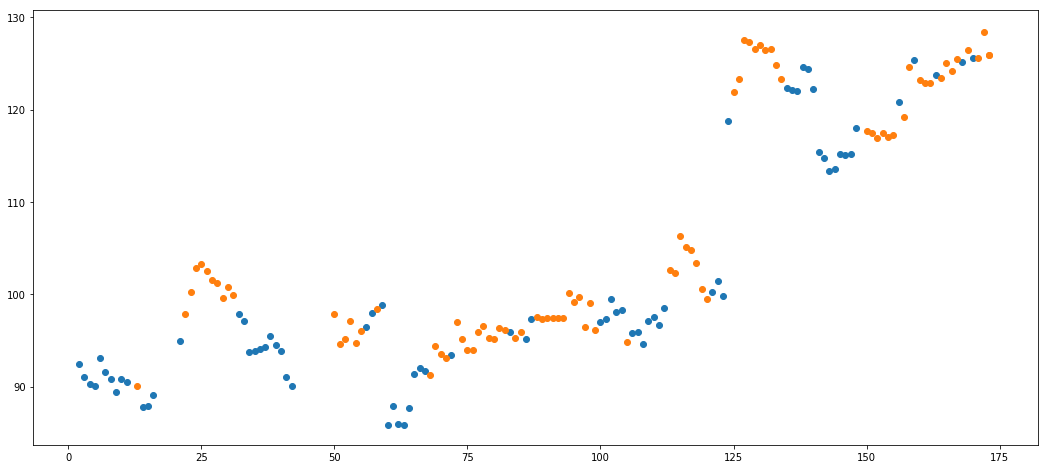

In [17]:
import random
random.seed(1997)

balance = 100000.0
cash_list= []
volume = 0
buyx = []
buyy =[]
selx = []
sely = []
for i in range(2,len(new_pred) - 1):
    prediction = new_pred[i]
    rand = random.randint(1, 100)
    if (prediction > new_pred[i-1] and balance != 0) or rand <= 5:
        if balance <= 10000:
            money = balance
            balance = 0
        else:
            money = 10000
            balance = balance - 10000
        volume += money / newy_test[i]
        buyx.append(i)
        buyy.append(newy_test[i])
        print("Buy " + str(newy_test[i]))
    elif(volume > 0 and prediction < new_pred[i-1] and prediction * 1.002 < new_pred[i-2]) or rand > 95:
        forSell = volume/4.0
        volume = volume*3.0/4.0
        balance += forSell * newy_test[i]
        selx.append(i)
        sely.append(newy_test[i])
        print("Sell " + str(newy_test[i]))
        print("Balance: " + str(balance))

if(volume != 0):
    balance += volume * newy_test[i]
    volume = 0
    selx.append(i)
    sely.append(newy_test[i])
    print("Sell : " + str(newy_test[i]))
    print("Balance : " + str(balance))
    
print("Balance : " + str(balance))
plt2.figure(figsize=(18,8))
plt2.scatter(buyx, buyy)
plt2.scatter(selx, sely)

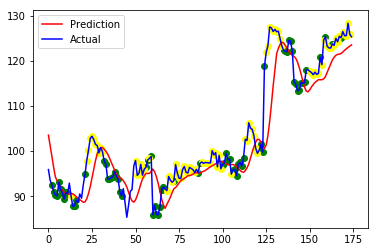

In [18]:
plt2.plot(new_pred,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.scatter(buyx, buyy, color='green')
plt2.scatter(selx, sely, color='yellow')
plt2.show()